# 🧹 Bank Marketing — Preprocessing & Feature Engineering Template

This notebook prepares the **UCI Bank Marketing** dataset for modeling.
It covers: loading, auditing, cleaning, handling special values, outliers, **feature engineering**, encoding, splitting, and exporting processed data.

> **Note:** The `duration` column is a known *data leakage* feature (call length is known only after the call). We drop it for pre-call targeting models.

## 0. Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from Scrap.Function_MLL import evaluate_models_with_numerical_features

## 1. Load Data

- Replace the path below with your dataset path.
- If you're using the UCI CSVs, load **bank-additional-full.csv** (recommended, ~41k rows).

In [57]:
# loading the dataset
df = pd.read_csv("F:/Ironhack/ML_Project/data/bank-full.csv", sep=";")
print(df.shape)
df.head()


(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2. Initial Audit

Quick overview: dtypes, missing/unknowns, unique values, and target distribution.

In [58]:
print(df.info())
print('\nTarget distribution:')
print(df['y'].value_counts(normalize=True).rename('ratio').round(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None

Target distribution:
y
no     0.883
yes    0.117
Name: ratio, dtype: float64


In [59]:
# Helper: show % of 'unknown' per categorical
def unknown_share(frame, cols=None):
    if cols is None:
        cols = frame.select_dtypes(include=['object']).columns.tolist()
    out = {}
    for c in cols:
        out[c] = (frame[c].astype(str).str.lower().eq('unknown').mean()*100).round(2)
    return pd.Series(out, name='% unknown').sort_values(ascending=False)

unknown_share(df)


poutcome     81.75
contact      28.80
education     4.11
job           0.64
marital       0.00
default       0.00
housing       0.00
loan          0.00
month         0.00
y             0.00
Name: % unknown, dtype: float64

In [60]:
# Cardinality of categoricals
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
pd.DataFrame({'unique': [df[c].nunique() for c in cat_cols]}, index=cat_cols).sort_values('unique', ascending=False)


,unique
job,12
month,12
education,4
poutcome,4
marital,3
contact,3
default,2
housing,2
loan,2
y,2


## 3. Cleaning

Decisions:
- Keep `'unknown'` as **valid category** (rename to `other/unknown`) to avoid bias.
- Drop `duration` (leakage for pre-call prediction).
- Ensure correct types; map target to binary.

In [61]:
df = df.copy()
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype('int8')
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])
for c in df.select_dtypes(include='object'):
    df[c] = df[c].str.strip().str.lower()

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,0


## 4. Outlier Treatment (Numeric)

Use IQR capping for skewed counts like `campaign`, `previous`, and potentially `balance`.

In [62]:
NUM_FOR_IQR = [c for c in ['campaign','previous','pdays','balance'] if c in df.columns]

def cap_outliers_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return s.clip(lower=lower, upper=upper)

for c in NUM_FOR_IQR:
    df[c] = cap_outliers_iqr(df[c])
df[NUM_FOR_IQR].describe().T


,count,mean,std,min,25%,50%,75%,max
campaign,45211.0,2.392228,1.600111,1.0,1.0,2.0,3.0,6.0
previous,45211.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pdays,45211.0,-1.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0
balance,45211.0,933.706974,1176.765369,-1962.0,72.0,448.0,1428.0,3462.0


## 5. Feature Engineering

Create informative features:

- `total_contacts` = `campaign` + `previous`
- `has_previous_contact` = 1 if `previous` > 0
- `pdays_category` bins
- `age_group`
- `has_any_loan`
- `balance_log`
- `seasonality: month sin/cos`

In [ ]:
# Feature engineering
# Create total_contacts and has_previous_contact features
if set(['campaign','previous']).issubset(df.columns):
    df['total_contacts'] = df['campaign'] + df['previous']
    df['has_previous_contact'] = (df['previous'] > 0).astype('int8')
    
# Create pdays categories
if 'pdays' in df.columns:
    df['pdays_category'] = pd.cut(
        df['pdays'],
        bins=[-1, 0, 5, 30, 999],
        labels=['no_previous', 'recent', 'month', 'long_ago'],
        include_lowest=True
    )


# Create a binary feature indicating if the client has either a housing or personal loan
if set(['housing','loan']).issubset(df.columns):
    df['has_any_loan'] = ((df['housing'] == 'yes') | (df['loan'] == 'yes')).astype('int8')
    
# Create age groups
if 'age' in df.columns:
    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 25, 35, 45, 55, 65, 100],
        labels=['<25', '25-34', '35-44', '45-54', '55-64', '65+'],
        include_lowest=True
    )

 
# Log-transform balance (shifted by +1 to handle zero and negative values)
if 'balance_log' in df.columns:
    df = df.drop(columns=['balance_log'])
    
df['balance_log'] = np.log1p(np.clip(df['balance'], a_min=-0.999999, a_max=None))

df.replace([np.inf, -np.inf], np.nan, inplace=True)
      
# Month	month_num	sin	cos
# Jan	1	0.5	     0.87
# Apr	4	1.0	     0.0
# Jul	7	0.0	    -1.0
# Oct	10	-1.0	 0.0
# Dec	12	-0.5	 0.87

if 'month' in df.columns:
    month_order = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    df['month_num'] = df['month'].map(month_order).astype('Int64')
    df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
      

df.head()




,age,job,marital,education,default,balance,housing,loan,contact,day,...,y,total_contacts,has_previous_contact,pdays_category,has_any_loan,age_group,month_num,month_sin,month_cos,balance_log
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,0,1,0,no_previous,1,55-64,5,0.5,-0.866025,7.670429
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,0,1,0,no_previous,1,35-44,5,0.5,-0.866025,3.401197
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,0,1,0,no_previous,1,25-34,5,0.5,-0.866025,1.098612
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,0,1,0,no_previous,1,45-54,5,0.5,-0.866025,7.317876
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,0,1,0,no_previous,0,25-34,5,0.5,-0.866025,0.693147


## 6. Quick EDA Checks

- Distributions & class imbalance
- Correlations among numeric features
- Correlation of numeric features with target `y`

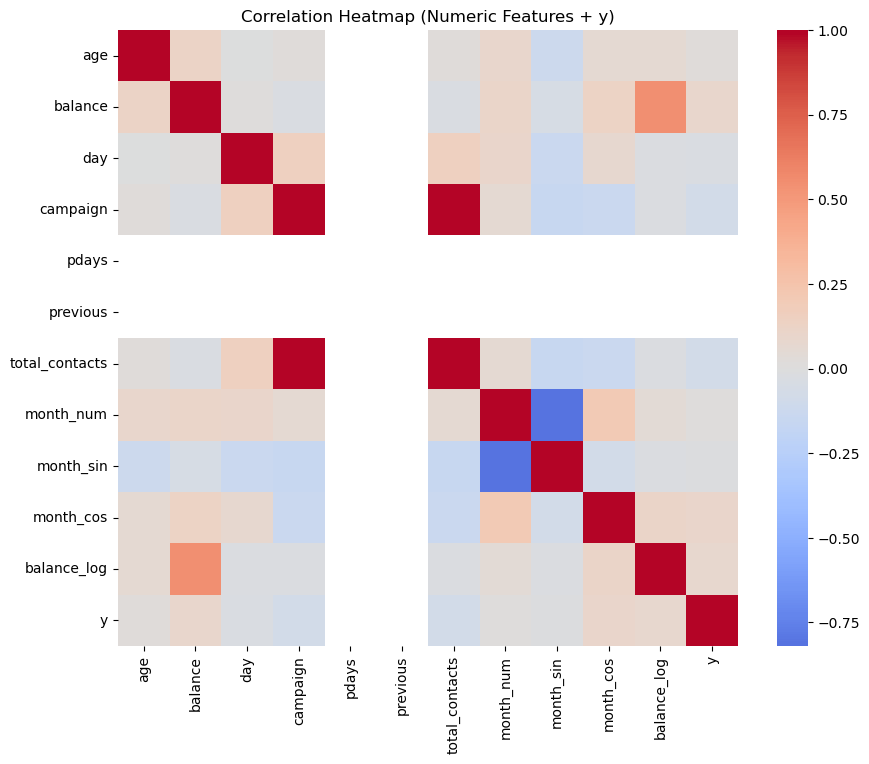

y                 1.000000
month_cos         0.099602
balance           0.092924
balance_log       0.081421
age               0.025155
month_num         0.018717
month_sin        -0.010559
day              -0.028348
campaign         -0.084061
total_contacts   -0.084061
pdays                  NaN
previous               NaN
Name: y, dtype: float64

In [70]:
num_cols = df.select_dtypes(include=['int64','float64','Int64']).columns.tolist()
corr = df[num_cols + ['y']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features + y)')
plt.show()

corr_y = corr['y'].sort_values(ascending=False)
corr_y


## 7. Export Processed Data

Save the transformed arrays and the preprocessor for reuse in modeling notebooks or apps.

In [77]:
# export preprocessed data
df.to_csv("F:/Ironhack/ML_Project/data/bank-full-preprocessed.csv", index=False)

